In [1]:
# Import necessary packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns; sns.set()
from eofs.xarray import Eof
from eofs.examples import example_data_path
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from typing import Union

(1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The data and land sea mask is available here: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download

In [3]:
# Import the file
data = '/data/keeling/a/mgraber2/Course scripts/ATMS523/M4data*.nc'
data = xr.open_mfdataset(data, combine='by_coords')
data

/tmp/ipykernel_169414/1264234164.py:3: UserWarning: Failed to load chunk manager entrypoint dask due to No module named 'xarray.core.daskmanager'. Skipping.
  data = xr.open_mfdataset(data, combine='by_coords')


<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 552, latitude: 521, longitude: 722)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB -180.0 -179.8 -179.5 ... 179.8 180.0
    expver      (valid_time) <U4 9kB dask.array<chunksize=(552,), meta=np.ndarray>
Data variables:
    sst         (valid_time, latitude, longitude) float32 831MB dask.array<chunksize=(138, 131, 121), meta=np.ndarray>
    lsm         (valid_time, latitude, longitude) float32 831MB dask.array<chunksize=(138, 131, 121), meta=np.ndarray>
    tcwv        (valid_time, latitude, longitude) float32 831MB dask.array<chunksize=(138, 131, 121), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-22T15:34 GRIB to CDM+CF via cfgrib-0.9.1...

/data/keeling/a/mgraber2/miniconda3/lib/python3.9/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/data/keeling/a/mgraber2/miniconda3/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/data/keeling/a/mgraber2/miniconda3/lib/python3.9/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


(2) From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data.

In [8]:
# Compute anomalies of sst and tcwv
# detrend the data
# Standardize the SST anomalies
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")
    
def linear_detrend(obj: Union[xr.DataArray, xr.Dataset], time_dim: str = "valid_time") -> Union[xr.DataArray, xr.Dataset]:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)
    
clim = data[['sst', 'tcwv']].groupby('valid_time.month').mean('valid_time')
data = data.unify_chunks()

# Subtract that monthly mean from each month in the full dataset
anomalies = data[['sst', 'tcwv']].groupby('valid_time.month') - clim

# Call the linear_detrend function to detrend the anomalies over time
detrended = linear_detrend(anomalies[["sst", "tcwv"]], time_dim="valid_time")

# Standardize the sst anomalies
detrended['sst'] = (detrended['sst'] - detrended['sst'].mean(dim='valid_time'))/detrended['sst'].std(dim='valid_time')

# merge with the lsm
ds = xr.merge([detrended, data['lsm']])

/data/keeling/a/mgraber2/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 46 times more chunks
  return self.array[key]
/tmp/ipykernel_169414/3982712414.py:6: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")
/data/keeling/a/mgraber2/miniconda3/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/data

In [10]:
# Save the new dataset as a netcdf file to load up next time
ds.to_netcdf('postdetrend_file.nc')

(3) Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.

In [11]:
# Assign sst to a variable
# Create an EOF solver to do the EOF analysis.
# Square-root of cosine of latitude weights 
# are applied before the computation of EOFs.
SST = ds['sst']
coslat = np.cos(np.deg2rad(SST.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(SST, weights=wgts)

/data/keeling/a/mgraber2/miniconda3/lib/python3.9/site-packages/dask/array/slicing.py:1086: PerformanceWarning: Increasing number of chunks by factor of 42
  p = blockwise(


In [12]:
# Get the first 5 eofs
eof5 = solver.eofsAsCorrelation(neofs=5)

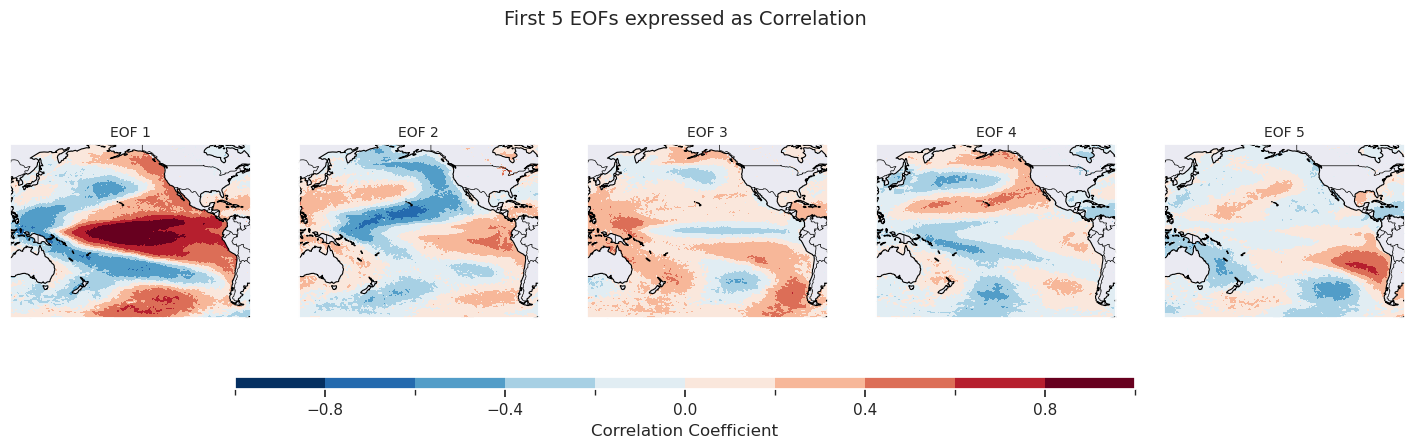

In [20]:
# Plot the first 5 eofs
projection = ccrs.PlateCarree(central_longitude=180)

fig, axes = plt.subplots(
    nrows=1, ncols=5, figsize=(18,4),
    subplot_kw={'projection': projection}
)
clevs = np.linspace(-1, 1, 11)
for i, ax in enumerate(axes):
    eof = eof5.isel(mode=i)
    im = eof.plot(
        ax=ax,
        levels=clevs,
        transform=ccrs.PlateCarree(),  # data are in 0–360° longitudes
        cmap='RdBu_r',
        add_colorbar=False
    )
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())
    ax.set_title(f'EOF {i+1}', fontsize=10)

# Adjust layout and add shared colorbar
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Correlation Coefficient')

fig.suptitle('First 5 EOFs expressed as Correlation', fontsize=14, y=1.05)
plt.show()

(4) Plot the percent of variance explained by the first 10 EOFs.

In [21]:
# Retrieve the variance for the eofs
varfrac = solver.varianceFraction()

(5.175555007994211e-16, 19.326385498046875)

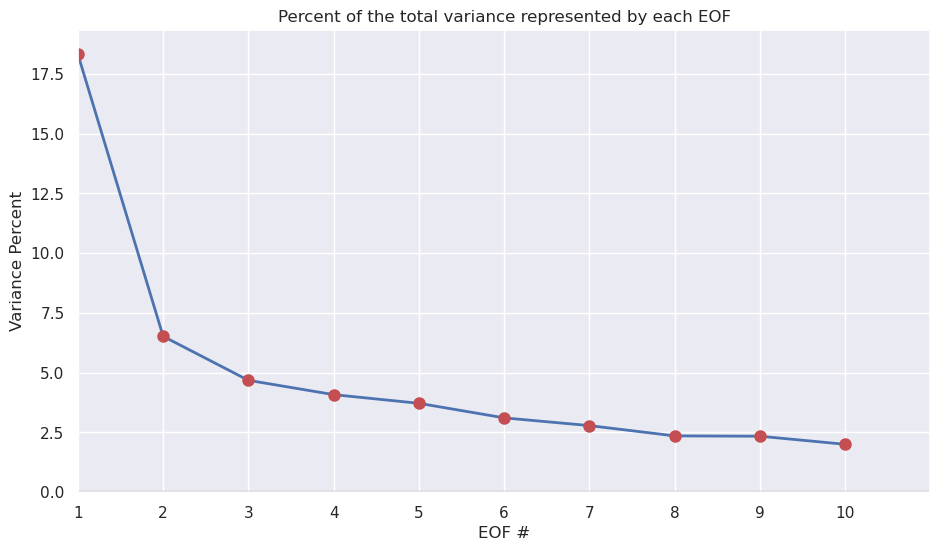

In [22]:
# Plot the percent of variance explained by the first 10 eofs
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10]*100, linewidth=2)
plt.plot(eof_num, varfrac[0:10]*100, linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Percent of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Percent')
plt.xlim(1, 11)
plt.ylim(np.min(varfrac*100), np.max(varfrac*100)+1)

(5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient (xarray.corr) of the reconstructed monthly time series (which will be "retrended" and "unstandardized") and the "observed" SST time series.

In [23]:
# Reconstruct the sst field using the first 5 EOFs
reconstruction = solver.reconstructedField(neofs=5)
reconstruction

<xarray.DataArray 'sst' (valid_time: 552, latitude: 521, longitude: 722)> Size: 831MB
dask.array<divide, shape=(552, 521, 722), dtype=float32, chunksize=(552, 131, 121), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB -180.0 -179.8 -179.5 ... 179.8 180.0
    number      (valid_time) int64 4kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    expver      (valid_time) <U4 9kB dask.array<chunksize=(138,), meta=np.ndarray>
    month       (valid_time) int64 4kB 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12
Attributes:
    long_name:  sst_reconstructed_with_5_EOFs

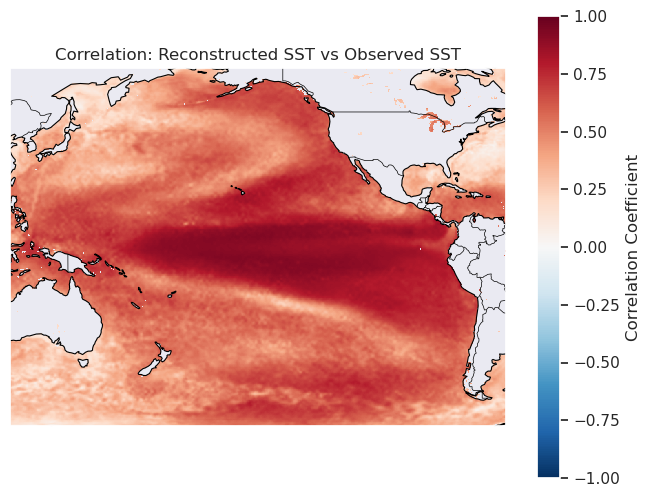

In [24]:
# Plot a map of the correlation coefficient between the reconstructed sst time series and the observed sst time series
corr = xr.corr(SST, reconstruction, dim='valid_time')
projection = ccrs.PlateCarree(central_longitude=180)

fig, ax = plt.subplots(figsize=(8,6), subplot_kw={'projection': projection})

# Plot correlation
im = corr.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmin=-1, vmax=1,
    add_colorbar=True,
    cbar_kwargs={'label': 'Correlation Coefficient'}
)

ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())

ax.set_title('Correlation: Reconstructed SST vs Observed SST')
plt.show()

(6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot). See anything interesting?

In [25]:
# Standardize the total column water vapor anomalies
tcwv_detrend = (detrended['tcwv'] - detrended['tcwv'].mean(dim='valid_time'))/detrended['tcwv'].std(dim='valid_time')

In [26]:
# Reconstruct the first eof
# Compute the correlation between eof1 and the tcwv_detrended
eof1 = solver.reconstructedField(neofs=1)
corr = xr.corr(eof1, tcwv_detrend, dim='valid_time')

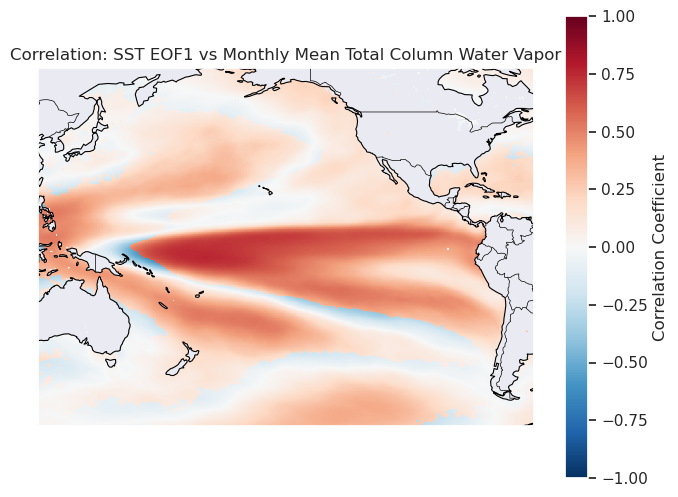

In [27]:
# Plot the correlation
projection = ccrs.PlateCarree(central_longitude=180)

fig, ax = plt.subplots(figsize=(8,6), subplot_kw={'projection': projection})

# Plot correlation
im = corr.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmin=-1, vmax=1,
    add_colorbar=True,
    cbar_kwargs={'label': 'Correlation Coefficient'}
)

ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())

ax.set_title('Correlation: SST EOF1 vs Monthly Mean Total Column Water Vapor')
plt.show()